Best attempts at reproducing minimal version of an algorithm proposed at https://arxiv.org/abs/2205.14977. Original code can be found [here](https://github.com/vistalab-technion/vqr)

In [1]:
from data_utils import create_joint_x_y
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn


num_points_to_generate = 1000
num_latent_points_to_generate = 1000


scaler = StandardScaler()
X, Y = create_joint_x_y(num_points_to_generate)

n, d = Y.shape
U = np.random.normal(size=(num_latent_points_to_generate, d))
m = U.shape[0]

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

embedding_dim = 5

feature_network = nn.Sequential(
    nn.Linear(X.shape[1], 100),
    nn.Softplus(),
    nn.Linear(100, embedding_dim),
    torch.nn.BatchNorm1d(
        num_features=embedding_dim, affine=False, track_running_stats=True,
    )
)

In [2]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
epsilon = 0.001
num_epochs = 1000

U_tensor = torch.tensor(U, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
X_tensor = torch.tensor(X, **device_and_dtype_specifications)
nu_tensor = torch.tensor(nu, **device_and_dtype_specifications)
mu_tensor = torch.tensor(mu, **device_and_dtype_specifications)
feature_network.to(**device_and_dtype_specifications)

psi_tensor = torch.full(size=(Y_tensor.shape[0], 1), fill_value=0.1, requires_grad=True, **device_and_dtype_specifications)
b_tensor = torch.zeros(*(m, embedding_dim), requires_grad=True, **device_and_dtype_specifications)

network_optimizer = torch.optim.Adam([dict(params=feature_network.parameters())], lr=0.1)
b_psi_optimizer = torch.optim.Adam([dict(params=[b_tensor, psi_tensor])], lr=0.1)

for epoch_idx in range(num_epochs):
        b_psi_optimizer.zero_grad()
        network_optimizer.zero_grad()

        phi_tensor = epsilon * torch.logsumexp(
                (
                        U_tensor @ Y_tensor.T  - # (m, q) @ (q, N)
                        b_tensor @ feature_network(X_tensor).T - # (m, 1) @ (1, N)
                        psi_tensor.reshape(1, -1) # (N, 1).reshape(1, N)
                ) / epsilon
                , dim = 1
        ) # (m, 1)

        objective = psi_tensor.T @ nu_tensor + phi_tensor.T @ mu_tensor # (N, 1).T @ (N, 1) + (m, 1).T @ (m, 1)

        objective.backward()
        b_psi_optimizer.step()
        network_optimizer.step()

with torch.no_grad():
        phi_tensor = epsilon * torch.logsumexp(
                (
                        U_tensor @ Y_tensor.T  - # (m, q) @ (q, N)
                        b_tensor @ feature_network(X_tensor).T - # (m, 1) @ (1, N)
                        psi_tensor.reshape(1, -1) # (N, 1).reshape(1, N)
                ) / epsilon
                , dim = 1
        ) # (m, 1)

phi_u = phi_tensor.detach().cpu().numpy()[:, None] # (m, 1)
b_u = b_tensor.detach().cpu().numpy() # (m, 1)
_ = feature_network.eval()

/var/folders/df/4t1l5hys3y7f1qn1w20x2cjw0000gn/T/ipykernel_31479/3192287138.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  objective = psi_tensor.T @ nu_tensor + phi_tensor.T @ mu_tensor # (N, 1).T @ (N, 1) + (m, 1).T @ (m, 1)


In [3]:
import torch
import numpy as np

def features_as_numpy_array(feature_network, X: torch.Tensor | np.ndarray):
    if isinstance(X, np.ndarray):
        X = torch.tensor(X)
    if feature_network.training:
        feature_network.eval()
    return feature_network(X).detach().cpu().numpy()

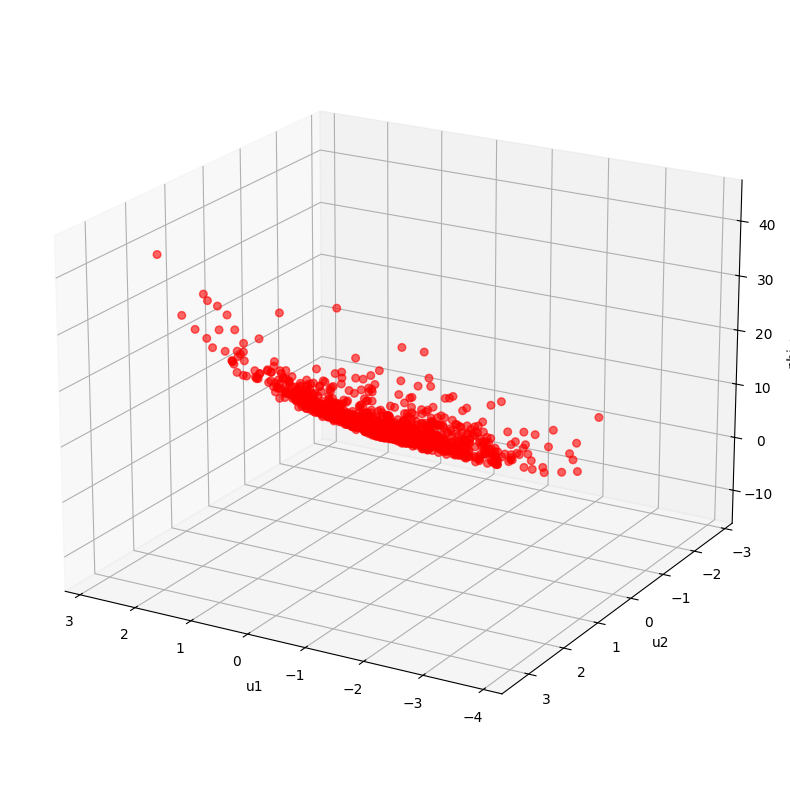

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
potential = b_u @ features_as_numpy_array(feature_network, X_tensor[0:1]).T + phi_u
scatter = ax.scatter(U[:, 0], U[:, 1], potential.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

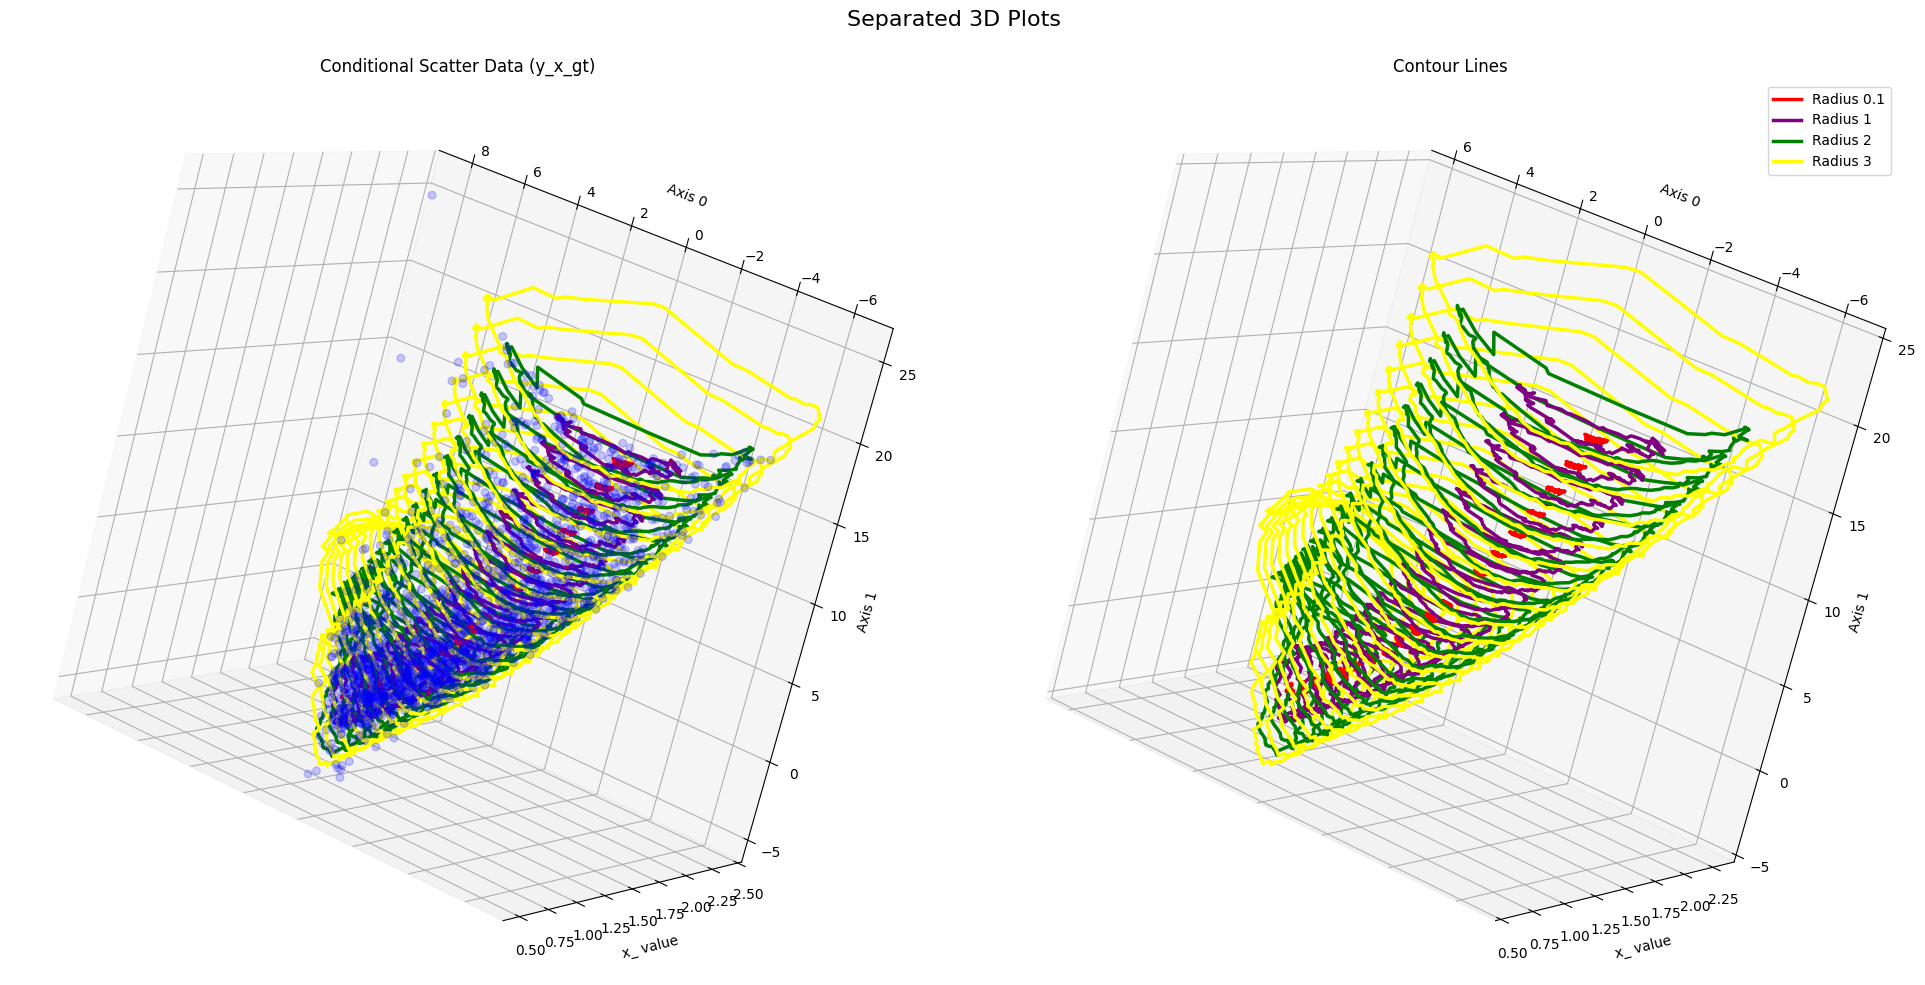

In [5]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline

from data_utils import create_conditional_x
from jaccobian_utils import estimate_gradients_for_points_knn

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):
    x = np.array([x_ / 100])[:, None]

    colors = ['red', 'purple', 'green', 'yellow']
    radii = [0.1, 1, 2, 3]
    for contour_radius, color in zip(radii, colors):
        pi = np.linspace(-np.pi, np.pi, 100) # Use linspace for a perfectly smooth circle

        u = np.stack([
            contour_radius * np.cos(pi),
            contour_radius * np.sin(pi),
        ])

        potential = b_u @ features_as_numpy_array(feature_network, x).T + phi_u
        pushforward_of_u = estimate_gradients_for_points_knn(U, potential, points_of_interest=u.T, k=30)

        z_line = np.full(pushforward_of_u.shape[0], x)
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

We can add additional parameter update loop with frozen network weights to prevent the quantile crossing effect.

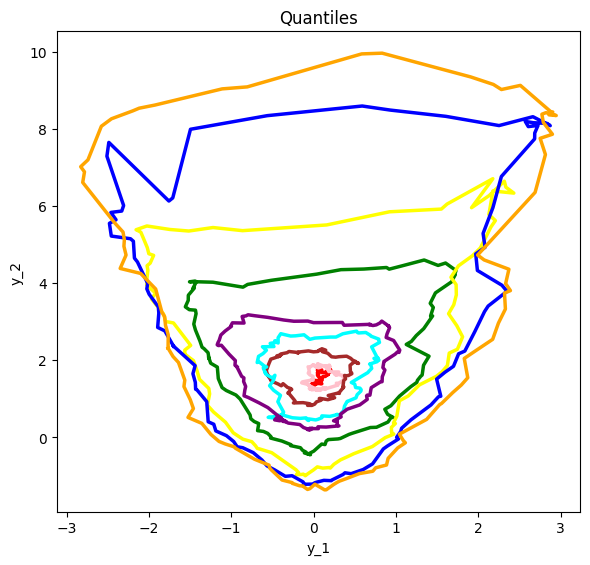

In [6]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline

from jaccobian_utils import estimate_gradients_for_points_knn

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.set_title('Quantiles')
ax1.set_xlabel('y_1')
ax1.set_ylabel('y_2')
x = np.array([1.])[:, None]


colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow', 'blue', 'orange']
radii = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4, 5]
for contour_radius, color in zip(radii, colors):
    pi = np.linspace(-np.pi, np.pi, 100) # Use linspace for a perfectly smooth circle

    u = np.stack([
        contour_radius * np.cos(pi),
        contour_radius * np.sin(pi),
    ])

    potential = b_u @ features_as_numpy_array(feature_network, x).T + phi_u
    pushforward_of_u = estimate_gradients_for_points_knn(U, potential, points_of_interest=u.T, k=30)

    ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, linewidth=2.5)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()